### RAG With Persistance Memory Using LangGraph

In [1]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Gemini model initialized for reranking


E0000 00:00:1759478002.801178   22101 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1759478002.805757   22101 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [3]:
## Document Ingestion And Processing
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [5]:
## chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
all_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

In [7]:
from langchain_community.vectorstores import FAISS
vector_store=FAISS.from_documents(
    documents=all_splits,
    embedding=embedding_model
)
print(f"Vector store created with {vector_store.index.ntotal} vectors")

Vector store created with 63 vectors


In [9]:
from langchain.agents import tool

@tool()
def retrieve(query:str):
    """Retrieve the information related to the query
    1. Perform similarity search on the vector store to get top 2 relevant documents.
    2. Format the retrieved documents to include source metadata and content.
    3. Return the formatted string and the list of retrieved documents."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [10]:
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

In [11]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

In [12]:
# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])
tools

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'retrieve': StructuredTool(name='retrieve', description='Retrieve the information related to the query\n    1. Perform similarity search on the vector store to get top 2 relevant documents.\n    2. Format the retrieved documents to include source metadata and content.\n    3. Return the formatted string and the list of retrieved documents.', args_schema=<class 'langchain_core.utils.pydantic.retrieve'>, func=<function retrieve at 0x7036583a9ee0>)}, tool_to_state_args={'retrieve': {}}, tool_to_store_arg={'retrieve': None}, handle_tool_errors=True, messages_key='messages')

In [13]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

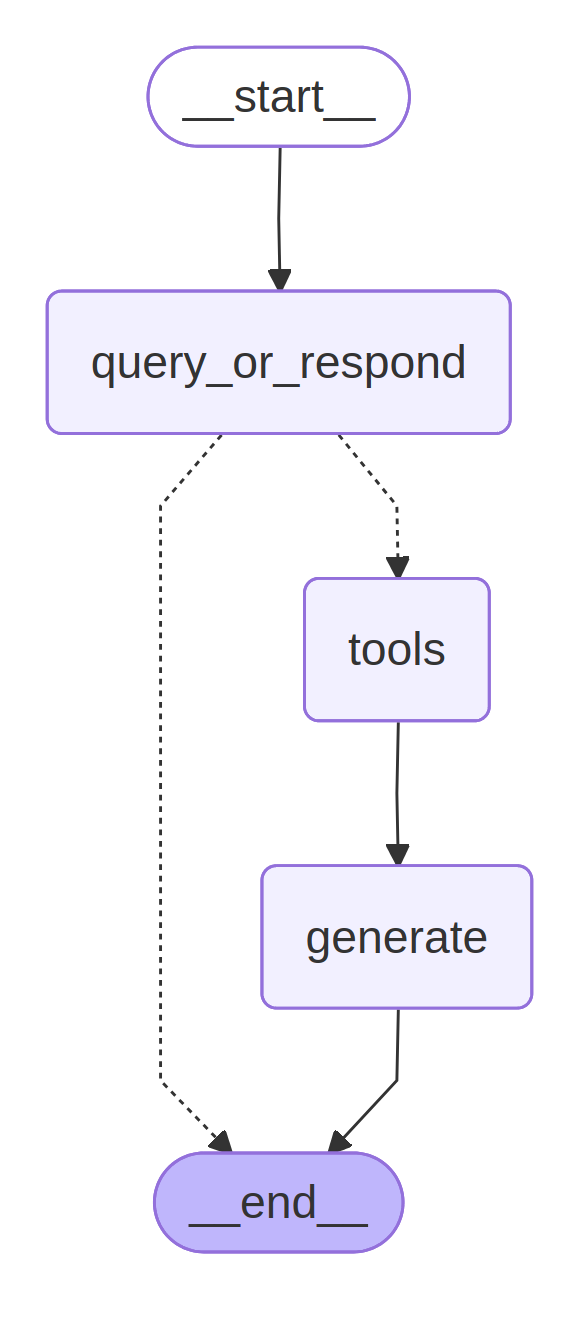

In [14]:
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()

# Build graph
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


# Visualize the workflow graph
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [15]:
# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [16]:
input_message="Hello"
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [17]:
vector_store.similarity_search("What is TAsk Decomposition")

[Document(id='e5319266-84e3-40eb-9efe-018f28301fab', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of 

In [18]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (a5f64a82-c8a0-4577-94e6-f89e883cd998)
 Call ID: a5f64a82-c8a0-4577-94e6-f89e883cd998
  Args:
    query: What is Task Decomposition?
================================= Tool Message =================================
Name: retrieve

('Source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\nContent: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as 

In [19]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (b0338b69-b85f-48cd-88e9-95f105009872)
 Call ID: b0338b69-b85f-48cd-88e9-95f105009872
  Args:
    query: common ways to do task decomposition
================================= Tool Message =================================
Name: retrieve

('Source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\nContent: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Def

In [20]:
### Conversation History
chat_history=graph.get_state(config).values["messages"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?
================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (a5f64a82-c8a0-4577-94e6-f89e883cd998)
 Call ID: a5f64a82-c8a0-4577-94e6-f89e883cd998
  Args:
    query: What is Task Decomposition?
================================= Tool Message =================================
Name: retrieve

('Source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\nContent: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother

### ReAct Agent Architecture-Persistant Memory

In [21]:
retrieve

StructuredTool(name='retrieve', description='Retrieve the information related to the query\n    1. Perform similarity search on the vector store to get top 2 relevant documents.\n    2. Format the retrieved documents to include source metadata and content.\n    3. Return the formatted string and the list of retrieved documents.', args_schema=<class 'langchain_core.utils.pydantic.retrieve'>, func=<function retrieve at 0x7036583a9ee0>)

In [22]:
from langgraph.prebuilt import create_react_agent
memory = MemorySaver()
agent_executor=create_react_agent(llm,[retrieve],checkpointer=memory)

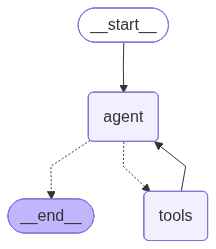

In [23]:
agent_executor

In [24]:
config = {"configurable": {"thread_id": "def235"}}

In [25]:
input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

In [26]:
for event in agent_executor.stream({"messages": [{"role": "user", "content": input_message}]},
                                   stream_mode="values",
                                   config=config):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (d672d95f-5af4-418a-9bd6-9bbc1146b026)
 Call ID: d672d95f-5af4-418a-9bd6-9bbc1146b026
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

('Source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\nContent: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner